In [1]:
%%capture
! pip install -U gym[atari]

In [2]:
%%capture
%%bash

# This is for saving videos of the environment in Google Colab
apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
pip install -U colabgymrender

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from collections import deque
from colabgymrender.recorder import Recorder

sns.set_context("talk")

# Solving the CartPole problem using Deep Q-learning

## Create environment.

In [4]:
env = gym.make("CartPole-v0")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

## Create a neural network 
Take an observation as input (len = 4) and returning an array of Q-values (len = 2) for this state.

In [ ]:
model = keras.models.Sequential([
  keras.layers.Dense(32, activation="elu", input_shape=input_shape),
  keras.layers.Dense(32, activation="elu"),
  keras.layers.Dense(n_outputs)
])

## Define epsilon greedy policy

In [5]:
def epsilon_greedy_policy(state, epsilon=0):
  if np.random.rand() < epsilon:
    return np.random.randint(2)  # A random action
  else:
    Q_values = model.predict(state[np.newaxis])
    return np.argmax(Q_values[0])  # The best action

In [6]:
replay_buffer = deque(maxlen=2000)

## Randomly selecting experiences from batch.

In [7]:
def sample_experiences(batch_size):

  # Create a random index vetor and use it to select previous experiences
  indices = np.random.randint(len(replay_buffer), size=batch_size)
  batch = [replay_buffer[index] for index in indices]

  # Return 5 array (length = batch_size) unpacking the experiences
  states, actions, rewards, next_states, dones = [
    np.array([experience[field_index] for experience in batch])
    for field_index in range(5)]

  return states, actions, rewards, next_states, dones

In [8]:
def play_one_step(env, state, epsilon):

  # Select an action following the epsilon greedy policy
  action = epsilon_greedy_policy(state, epsilon)

  # Play one step
  next_state, reward, done, info = env.step(action)

  # Append result to the replay buffer
  replay_buffer.append((state, action, reward, next_state, done))

  return next_state, reward, done, info

In [9]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):

  # Sample a batch of experiences
  experiences = sample_experiences(batch_size)
  states, actions, rewards, next_states, dones = experiences

  # Use the DQN to predict the Q-value for each possible action
  next_Q_values = model.predict(next_states)

  # Only keep the maximum Q-value
  max_next_Q_values = np.max(next_Q_values, axis=1)

  # Use the Q-value update equation
  target_Q_values = (rewards +
    (1 - dones) * discount_factor * max_next_Q_values)
  
  # Mask the predicted Q-values we don't need
  mask = tf.one_hot(actions, n_outputs)

  with tf.GradientTape() as tape:
    all_Q_values = model(states)
    Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)

    # Compute the loss (mean squared error between target and prediction)
    loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

  # Perform Gradient Descent step
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

## Train the agent

In [10]:
total_reward = []
for episode in range(600):
  obs = env.reset()
  sum_reward = 0
  for step in range(200):
    epsilon = max(1 - episode / 500, 0.01)
    obs, reward, done, info = play_one_step(env, obs, epsilon)
    sum_reward += reward
    if done:
      break
  if episode > 50:
    training_step(batch_size)
  
  total_reward.append(sum_reward)

# Performances

<Figure size 936x360 with 0 Axes>

Text(0.5, 0, 'Episode')

Text(0, 0.5, 'Summ of rewards')

(0.0, 200.0)

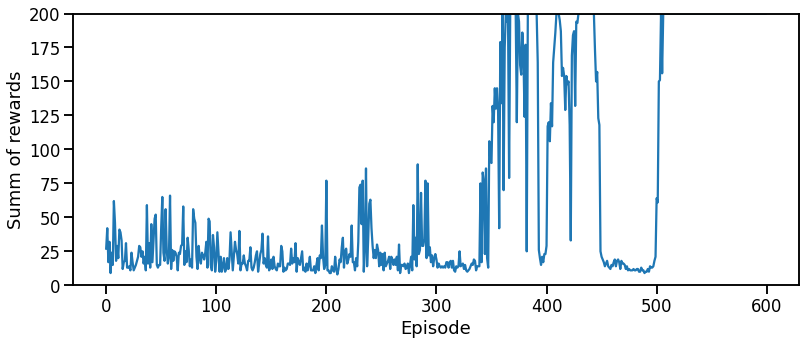

In [11]:
plt.figure(figsize=(13, 5))
plt.plot(total_reward)
plt.xlabel('Episode')
plt.ylabel('Summ of rewards')
plt.ylim(0, 200)

In [15]:
# Create environment
env = gym.make("CartPole-v0")

# Use this if you want to visualize the environment in Google Colab
directory = './video'
env = Recorder(env, directory)

In [18]:
state = env.reset()

for step in range(1200):

  # Select the highest Q-value learned by the agent
  Q_values = model.predict(state[np.newaxis])
  action = np.argmax(Q_values[0])

  state, reward, done, info = env.step(action)

  if done:
    print(f'Episode ended at step {step}')
    break

env.play()

  9%|▉         | 18/201 [00:00<00:01, 176.10it/s]

Episode ended at step 199


100%|██████████| 201/201 [00:00<00:00, 271.67it/s]


# Exercices

Chose one of the following exercises for the second hour.

* Use deep Q-learning to solve the MontainCar problem (or any other problem you would like to try).

* The current implementation is still imperfect for at least two reasons. **1)** It is prone to catastrophic forgetting, as we can see in the fluctuation of the total reward. **2)** The limit of 200 steps can make the agent learn unstable solutions (e.g solution that will pass the 200 first steps but that will fail at step 201, as we can see in the video). This can be improved in many ways. Try to fix one of these problems (or both).